In [80]:
# import useful library
from collections import Counter
import operator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Flatten, TimeDistributed
from tensorflow.keras.layers import RepeatVector, Embedding, Input, LSTM
from tensorflow.keras.layers import Conv1D, MaxPool1D, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(level=logging.INFO)

In [4]:
# import dataset from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d harishreddy18/english-to-french

  0% 0.00/2.50M [00:00<?, ?B/s]
100% 2.50M/2.50M [00:00<00:00, 81.9MB/s]


In [5]:
# unzipping dataset
!unzip "english-to-french.zip"

Archive:  english-to-french.zip
  inflating: small_vocab_en.csv      
  inflating: small_vocab_fr.csv      


In [6]:
df_english = pd.read_csv("/content/small_vocab_en.csv", sep='\t', names=['english'])
df_french = pd.read_csv("/content/small_vocab_fr.csv", sep='\t', names=['french'])

In [7]:
print("Number of dataset English: ", df_english.shape)
print("Number of dataset French: ", df_french.shape)

Number of dataset English:  (137860, 1)
Number of dataset French:  (137860, 1)


In [8]:
df = pd.concat([df_english, df_french], 1)
df.head()

,english,french
0,"new jersey is sometimes quiet during autumn , ...",new jersey est parfois calme pendant l' automn...
1,the united states is usually chilly during jul...,les états-unis est généralement froid en juill...
2,"california is usually quiet during march , and...","california est généralement calme en mars , et..."
3,the united states is sometimes mild during jun...,"les états-unis est parfois légère en juin , et..."
4,"your least liked fruit is the grape , but my l...","votre moins aimé fruit est le raisin , mais mo..."


In [9]:
# Make a sampel data
df_sampel = df.sample(n=35000)

In [10]:
print("Shape of dataset sampel:", df_sampel.shape)

Shape of dataset sampel: (35000, 2)


In [11]:
# 1. remove punctuation function (CLEANING SECTION)
import string
def clean_string(info):
  clean = [(char) for char in info if char not in string.punctuation]
  return "".join(clean)

In [12]:
df_sampel['english'] = df_sampel['english'].apply(clean_string)
df_sampel['french'] = df_sampel['french'].apply(clean_string)
df_sampel.head()

,english,french
19800,you like lemons bananas and pears,vous aimez les citrons les bananes et les poi...
76310,france is usually mild during autumn and it i...,la france est généralement doux à lautomne et...
115911,india is sometimes beautiful during autumn bu...,l inde est parfois belle en automne mais il e...
83815,the united states is usually dry during may b...,les étatsunis est généralement sec au mois de ...
4002,the united states is never relaxing during dec...,les étatsunis est jamais relaxant en décembre ...


In [13]:
# 2. Splitting dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_sampel['english'].tolist(), 
                                                    df_sampel['french'].tolist(),
                                                    test_size=0.2, random_state=11)

In [14]:
# show sampel sentence
print("Sampel sentence in \nEnglish: {} \nFrench: {}".format(X_train[3], y_train[3]))

Sampel sentence in 
English: the united states is usually freezing during september  and it is never pleasant in april  
French: les étatsunis est le gel habituellement en septembre  et il est jamais agréable en avril 


In [15]:
# 3. Preprocessing NLP
def preprocess(sentences):
  punc = '''!()-[];:'"\,<>./?@@$#%^&*_~'''
  for sen in sentences:
    if sen in punc:
      sentences = sentences.replace(sen, "")
  line = sentences.split()
  line = [word.lower() for word in line]
  check_re = re.compile('[^%s]' % re.escape(string.printable))
  line = [check_re.sub('', w) for w in line]
  return " ".join(line)

In [16]:
english_sentences = []          
french_sentences = []         
french_sentences_inputs = []

In [17]:
for i in range(len(X_train)):
  input_sentence = preprocess(X_train[i])
  output = y_train[i]
  output_sentence = output + ' <eos>'
  output_sentence_input = '<sos>' + output

  english_sentences.append(input_sentence)
  french_sentences.append(output_sentence)
  french_sentences_inputs.append(output_sentence_input)

In [18]:
print("Number of English samples :", len(english_sentences))
print("Number of output samples:", len(french_sentences))
print("Number of input output samples:", len(french_sentences_inputs))

Number of English samples : 28000
Number of output samples: 28000
Number of input output samples: 28000


In [20]:
# punctuation and STOPWORDS in NLTK
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
english_words = []
french_words = []

In [22]:
def unique_word(x, word_list):
  for word in x.split():
    if word not in word_list:
      word_list.append(word)

In [23]:
df_sampel['english'].apply(lambda x:unique_word(x, english_words))
df_sampel['french'].apply(lambda x:unique_word(x, french_words))

19800     None
76310     None
115911    None
83815     None
4002      None
          ... 
45843     None
107715    None
89360     None
133478    None
65815     None
Name: french, Length: 35000, dtype: object

In [28]:
print(english_words[0:5])
print("number of data", len(english_words))

['you', 'like', 'lemons', 'bananas', 'and']
number of data 199


In [29]:
print(french_words[0:5])
print("number of data", len(french_words))

['vous', 'aimez', 'les', 'citrons', 'bananes']
number of data 335


In [31]:
# all words in dataset
words = []
for i in df_sampel['english']:
  for word in i.split():
    words.append(word)
words[0:5]

['you', 'like', 'lemons', 'bananas', 'and']

In [43]:
# sort dictionary by values
english_words_counts = sorted(pd.Series(words).value_counts().items(), 
                              key=operator.itemgetter(1), reverse=True)

In [45]:
english_words_counts[0:5]

[('is', 52288),
 ('in', 19143),
 ('it', 19045),
 ('during', 18985),
 ('the', 17231)]

In [46]:
# append the values to a list for visualization
english_words = []
english_counts =[]
for i in range(len(english_words_counts)):
  english_words.append(english_words_counts[i][0])
  english_counts.append(english_words_counts[i][1])

In [47]:
english_words[0:5]

['is', 'in', 'it', 'during', 'the']

In [48]:
english_counts[0:5]

[52288, 19143, 19045, 18985, 17231]

In [50]:
# plot barplot
import plotly.express as px
fig = px.bar(x = english_words, y=english_counts)
fig.show()

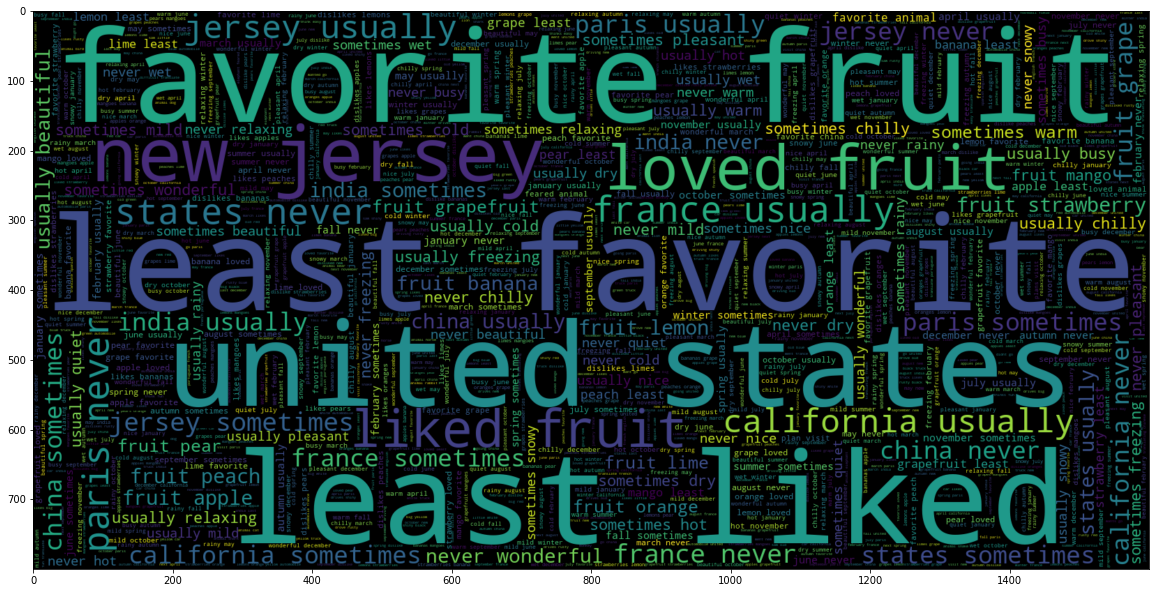

In [51]:
# Wordcloud
plt.figure(figsize = (20,20))
wordcloud = WordCloud(max_words = 2000, width = 1600,
                      height = 800).generate(" ".join(df_sampel.english))
plt.imshow(wordcloud, interpolation='bilinear')

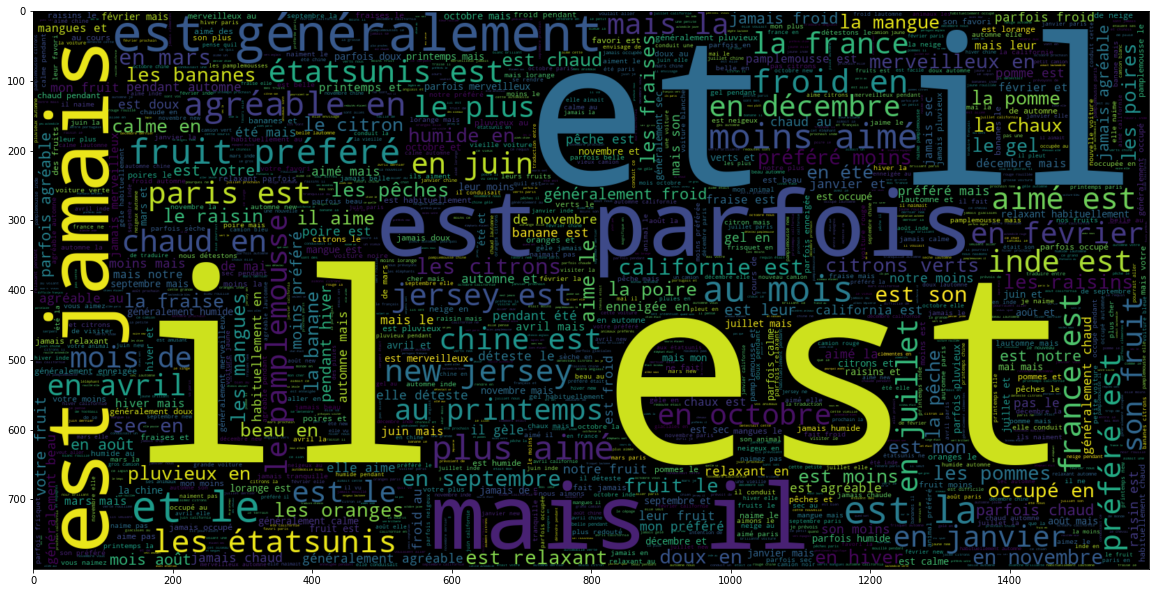

In [61]:
# Wordcloud French
plt.figure(figsize = (20,20))
wordcloud = WordCloud(max_words = 2000, width = 1600,
                      height = 800).generate(" ".join(df_sampel.french))
plt.imshow(wordcloud, interpolation='bilinear')

In [58]:
df_sampel.english.iloc[0]

'you like lemons  bananas  and pears '

In [59]:
nltk.word_tokenize(df_sampel.english.iloc[0])

['you', 'like', 'lemons', 'bananas', 'and', 'pears']

In [62]:
# Count maximum number of words per document, usefull for embeddings
maxlen_english = 0
for doc in df_sampel.english:
  tokens = nltk.word_tokenize(doc)
  if (maxlen_english < len(tokens)):
    maxlen_english = len(tokens)

print("Maximum number of words in English document: ", maxlen_english)

Maximum number of words in English document:  15


In [63]:
maxlen_french = 0
for doc in df_sampel.french:
  tokens = nltk.word_tokenize(doc)
  if (maxlen_french < len(tokens)):
    maxlen_french = len(tokens)

print("Maximum number of words in French document: ", maxlen_french)

Maximum number of words in French document:  21


In [64]:
# 3. Tokenization and padding
def tokenize_padding(x, maxlen):
  tokenizer = Tokenizer(char_level = False)
  tokenizer.fit_on_texts(x)
  sequences = tokenizer.texts_to_sequences(x)
  padd = pad_sequences(sequences, maxlen=maxlen, padding='post')
  return tokenizer, sequences, padd

In [66]:
# tokenize and padding to the data 
x_tokenizer, x_sequences, x_padded = tokenize_padding(df_sampel.english, maxlen_english)
y_tokenizer, y_sequences, y_padded = tokenize_padding(df_sampel.french,  maxlen_french)

In [67]:
# TOTAL Vocab Size, since we added padding so we add 1 to the total word
english_vocab_size = len(english_words) + 1
print("Complete English vocab Size: ", english_vocab_size)

Complete English vocab Size:  200


In [68]:
french_vocab_size = len(french_words) + 1
print("Complete English vocab Size: ", french_vocab_size)

Complete English vocab Size:  336


In [74]:
print(" The tokenized version for English document: \n", df_sampel.english[-1:].item(),
      "\n is: \n", x_padded[-1:])

 The tokenized version for English document: 
 france is sometimes wonderful during september  and it is never hot in april  
 is: 
 [[19  1  8 45  4 53  7  3  1 10 64  2 42  0  0]]


In [75]:
print(" The tokenized version for French document: \n", df_sampel.french[-1:].item(),
      "\n is: \n", y_padded[-1:])

 The tokenized version for French document: 
 la france est parfois merveilleux en septembre  et il est jamais chaud en avril  
 is: 
 [[ 7 30  1  8 53  2 52  6  3  1  9 20  2 46  0  0  0  0  0  0  0]]


In [100]:
# Splitting based on padding
x_train , x_test , y_train , y_test  =  train_test_split(x_padded , y_padded  ,test_size = 0.1)

In [110]:
# BUILD Model
# Sequential Model
model = Sequential()

# Embedding Layer
model.add(Embedding(english_vocab_size, 128, 
                    input_length=maxlen_english,
                    mask_zero=True))
model.add(LSTM(256))
model.add(RepeatVector(maxlen_french))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(french_vocab_size, activation='softmax')))
model.compile(optimizer=Adam(lr = 1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 15, 128)           25600     
_________________________________________________________________
lstm_6 (LSTM)                (None, 256)               394240    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 21, 256)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 21, 256)           525312    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 21, 336)           86352     
Total params: 1,031,504
Trainable params: 1,031,504
Non-trainable params: 0
_________________________________________________________________


In [111]:
# change the shape of target from 2D to 3D
y_train = np.expand_dims(y_train, axis=2)
y_train.shape

(31500, 21, 1, 1, 1)

In [112]:
history = model.fit(x_train, y_train, batch_size= 1024, validation_split=0.1, epochs=10)

Epoch 1/10
28/28 [==============================] - 119s 4s/step - loss: 3.8744 - accuracy: 0.3961 - val_loss: 3.0833 - val_accuracy: 0.3861
Epoch 2/10
28/28 [==============================] - 110s 4s/step - loss: 2.8484 - accuracy: 0.3357 - val_loss: 2.6697 - val_accuracy: 0.2964
Epoch 3/10
28/28 [==============================] - 110s 4s/step - loss: 2.5416 - accuracy: 0.2651 - val_loss: 2.4267 - val_accuracy: 0.2501
Epoch 4/10
28/28 [==============================] - 110s 4s/step - loss: 2.3464 - accuracy: 0.2302 - val_loss: 2.2642 - val_accuracy: 0.2277
Epoch 5/10
28/28 [==============================] - 111s 4s/step - loss: 2.2199 - accuracy: 0.2234 - val_loss: 2.1611 - val_accuracy: 0.2129
Epoch 6/10
28/28 [==============================] - 111s 4s/step - loss: 2.1334 - accuracy: 0.2186 - val_loss: 2.0730 - val_accuracy: 0.2111
Epoch 7/10
28/28 [==============================] - 111s 4s/step - loss: 2.0161 - accuracy: 0.2161 - val_loss: 1.9061 - val_accuracy: 0.2098
Epoch 8/10
28

In [113]:
#save model
model.save("weights.h5")

In [114]:
y_pred = model.predict(x_test)

In [115]:
# function prediction
def predict_data(x, x_tokenizer = x_tokenizer, y_tokenizer = y_tokenizer):
  predict = model.predict(x)[0]
  id_to_word = {id: word for word, id in y_tokenizer.word_index.items()}
  id_to_word[0] = ''
  return ' '.join([id_to_word[j] for j in np.argmax(predict, 1)])

In [116]:
# function to obtain the text from padded variables
def pad_to_text(padded, tokenizer):
    id_to_word = {id: word for word, id in tokenizer.word_index.items()}
    id_to_word[0] = ''
    return ' '.join([id_to_word[j] for j in padded])

In [118]:
for i in range(5):
  print('Original English word - {}\n'.format(pad_to_text(x_test[i], x_tokenizer)))
  print('Original French word - {}\n'.format(pad_to_text(y_test[i], y_tokenizer)))
  print('Predicted French word - {}\n\n\n\n'.format(predict_data(x_test[i:i+1])))

Original English word - india is usually pleasant during october but it is mild in autumn   

Original French word - l inde est généralement agréable en octobre mais il est doux à l automne       

Predicted French word - la est est parfois en en mais il il est est en en        




Original English word - he likes grapefruit peaches and mangoes         

Original French word - il aime le pamplemousse les pêches et les mangues            

Predicted French word - elle aime les les les et et les             




Original English word - china is never freezing during april but it is never rainy in winter  

Original French word - chine est jamais le gel en avril mais jamais pluvieux en hiver         

Predicted French word - la est est parfois en en mais mais il est est est en en       




Original English word - paris is warm during winter and it is usually relaxing in october   

Original French word - paris est chaud pendant l hiver et il est relaxant habituellement en octobre       